<a href="https://colab.research.google.com/github/dawissem/fullpack-ia-module-1/blob/main/fraude_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⬆️  Uploade ton fichier kaggle.json (Kaggle → Account → Create API Token)


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.17557

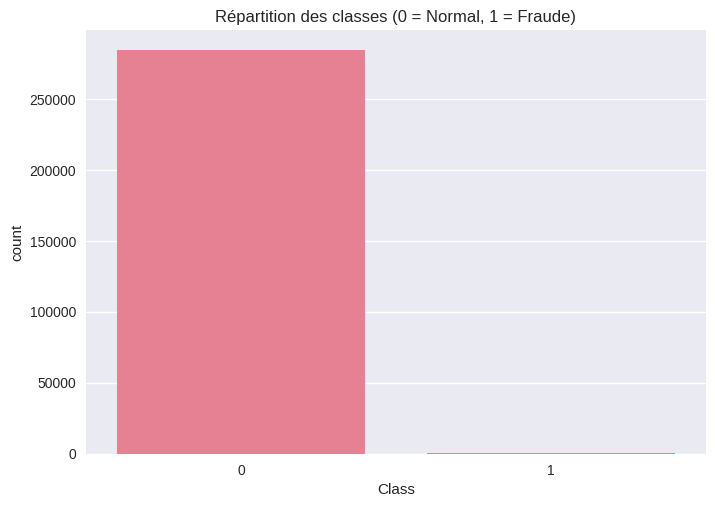

✅ After SMOTE: [199020 199020]
Fitting 3 folds for each of 8 candidates, totalling 24 fits
🔍 Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
📊 Classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.47      0.82      0.60       148

    accuracy                           1.00     85443
   macro avg       0.74      0.91      0.80     85443
weighted avg       1.00      1.00      1.00     85443



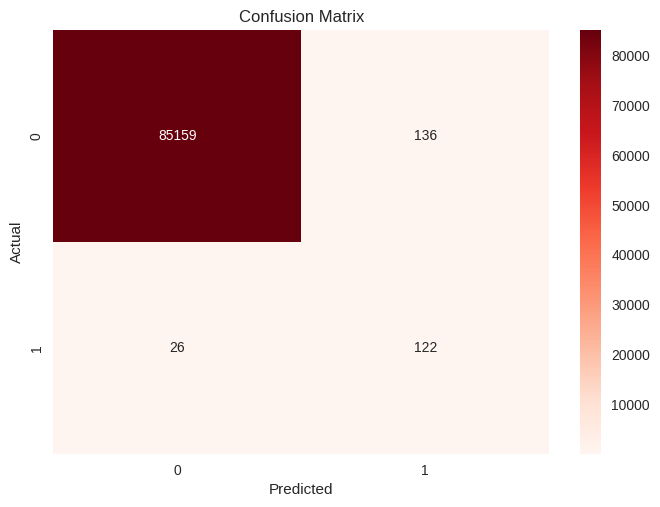

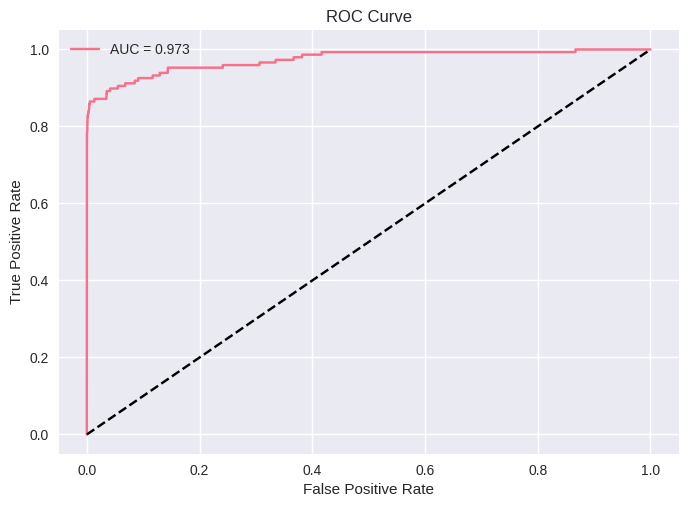

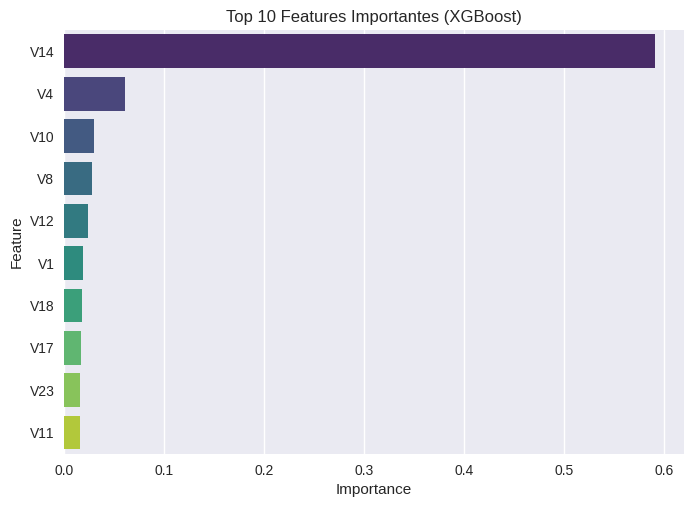

In [18]:
# 🕵️‍♂️ Détection de fraudes CB – Kaggle download + SMOTE + XGBoost – Bloc unique Colab
# =========================================================================

# 0) Installations Python & system
!pip install -q imbalanced-learn xgboost kaggle
import os, zipfile, json, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings("ignore")

# 1) Authentification Kaggle ------------------------------------------------
# Si les variables d'environnement ne sont pas déjà définies : upload kaggle.json.
if ("KAGGLE_USERNAME" not in os.environ) or ("KAGGLE_KEY" not in os.environ):
    from google.colab import files
    print("⬆️  Uploade ton fichier kaggle.json (Kaggle → Account → Create API Token)")
    files.upload()                                # Sélectionne kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

# 2) Téléchargement + décompression du dataset ------------------------------
!kaggle datasets download -d mlg-ulb/creditcardfraud -p /content -q
!unzip -o /content/creditcardfraud.zip -d /content/data >/dev/null
csv_path = "/content/data/creditcard.csv"

# 3) Imports ML -------------------------------------------------------------
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# 4) Chargement & EDA rapide -----------------------------------------------
df = pd.read_csv(csv_path)
print(df.head(), "\n")
print(df['Class'].value_counts())

sns.countplot(x='Class', data=df)
plt.title("Répartition des classes (0 = Normal, 1 = Fraude)")
plt.show()

# 5) Préparation des données ------------------------------------------------
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42)

# 6) SMOTE pour équilibrage -------------------------------------------------
X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("✅ After SMOTE:", np.bincount(y_res))

# 7) XGBoost + GridSearch ---------------------------------------------------
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth'   : [3, 5],
    'learning_rate': [0.1, 0.01]
}
grid = GridSearchCV(xgb, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_res, y_res)
best_model = grid.best_estimator_
print("🔍 Best params:", grid.best_params_)

# 8) Évaluation -------------------------------------------------------------
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("📊 Classification report\n", classification_report(y_test, y_pred))

# Confusion matrix
conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True); plt.show()

# 9) Importance des variables ----------------------------------------------
importances = best_model.feature_importances_
features = df.drop(['Time', 'Class'], axis=1).columns
imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}) \
           .sort_values('Importance', ascending=False).head(10)

sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')
plt.title("Top 10 Features Importantes (XGBoost)")
plt.show()
